# Projet 9 : Réaliser une application de recommandation de contenu

Problématique : My Content est une start-up qui veut encourager la lecture en recommandant des contenus pertinents pour ses utilisateurs. Le but est de développer un MVP grâce à des données disponible sur internet. L'application devra renvoyer une sélection de cinq articles.

Concernant l'architecture de l'application, il faudra avoir une architecture serverless : API + Azure Fonction ou Azure fonction. <br>
Notre choix s'est porté sur l'azure fonction, car nous pouvons directement l'interroger via une requête http pour obtenir les recommandations. Il n'est donc pas nécessaire de réaliser une API en plus.

## Import des bibliothèques

In [23]:
import pandas as pd

In [24]:
import sys
# Insert the path of modules folder
sys.path.insert(0, "Package")

# Import the module0 directly since
# the current path is of modules.
import Scripts_Analyse01 as pk
import Scripts_AnalyseMulti01 as pk_multi
import Scripts_AnalyseMulti02_Unsupervised as pk_multi_unsp
import Scripts_AnalyseMulti02_Supervised as pk_multi_sup

D:\ProgramFiles\Anaconda3\envs\venv_009_2\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used


## Import des données

Commençons par la table article.

In [25]:
articles = pd.read_csv("Input\\articles_metadata.csv")

In [4]:
articles

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


Nous avons 364 047 lignes et 5 variables.

Vérifions si nous avons des doublons.

In [5]:
articles.duplicated().sum()

0

In [6]:
articles.duplicated(["article_id", "category_id"]).sum()

0

Il n'y a aucun doublon dans cette table.

Importons les fichiers contenant les clicks des utilisateurs.

In [26]:
from pathlib import Path
import pandas as pd
import numpy as np

path = r'Input\\clicks\\clicks'  # or unix / linux / mac path

# get the files from the path provided in the OP
files = Path(path).glob('*.csv')  # .rglob to get subdirectories

In [27]:
dfs = list()
for f in files:
    print(f)
    data = pd.read_csv(f)
        ## .stem is method for pathlib objects to get the filename w/o the extension
    data['file'] = f
    if 'df' in locals():
        df = pd.concat([df , data], ignore_index=True)
    else:
        df=data

Input\clicks\clicks\clicks_hour_000.csv
Input\clicks\clicks\clicks_hour_001.csv
Input\clicks\clicks\clicks_hour_002.csv
Input\clicks\clicks\clicks_hour_003.csv
Input\clicks\clicks\clicks_hour_004.csv
Input\clicks\clicks\clicks_hour_005.csv
Input\clicks\clicks\clicks_hour_006.csv
Input\clicks\clicks\clicks_hour_007.csv
Input\clicks\clicks\clicks_hour_008.csv
Input\clicks\clicks\clicks_hour_009.csv
Input\clicks\clicks\clicks_hour_010.csv
Input\clicks\clicks\clicks_hour_011.csv
Input\clicks\clicks\clicks_hour_012.csv
Input\clicks\clicks\clicks_hour_013.csv
Input\clicks\clicks\clicks_hour_014.csv
Input\clicks\clicks\clicks_hour_015.csv
Input\clicks\clicks\clicks_hour_016.csv
Input\clicks\clicks\clicks_hour_017.csv
Input\clicks\clicks\clicks_hour_018.csv
Input\clicks\clicks\clicks_hour_019.csv
Input\clicks\clicks\clicks_hour_020.csv
Input\clicks\clicks\clicks_hour_021.csv
Input\clicks\clicks\clicks_hour_022.csv
Input\clicks\clicks\clicks_hour_023.csv
Input\clicks\clicks\clicks_hour_024.csv


Regardons la table.

In [28]:
df.head(2)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,file
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,Input\clicks\clicks\clicks_hour_000.csv
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,Input\clicks\clicks\clicks_hour_000.csv


In [29]:
df.shape

(2988181, 13)

Nous avons 2 988 181 lignes et 13 variables.

Vérifions les doublons.

In [10]:
df.duplicated().sum()

0

In [11]:
df.duplicated(["user_id", "session_id", "click_article_id", "click_timestamp"]).sum()

0

Nous avons aucun doublon.

Importons le fichier d'embeddings des articles : c'est la matrice qui contient les incorporations de contenu des articles (vecteurs à 250 dimensions), qui ont été entrainées sur le texte et les métadonnées des articles par le module ACR de Chamelon (cf le document https://arxiv.org/abs/1808.00076)

In [31]:
art_embed = pd.read_pickle('Input\\articles_embeddings.pickle')
art_embed.shape

(364047, 250)

La matrice contient bien les 364 047 articles et a 250 dimensions.

In [13]:
art_embed

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

Maintenant que nous avons importé nos données, nous pouvons passer à l'étape suivante.

## Construction de la base de données

### Création de notre jeu de données : jointure des tables

Fusionnons nos deux tables.

In [15]:
df

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,file
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,Input\clicks\clicks\clicks_hour_000.csv
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,Input\clicks\clicks\clicks_hour_000.csv
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,Input\clicks\clicks\clicks_hour_000.csv
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2,Input\clicks\clicks\clicks_hour_000.csv
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,Input\clicks\clicks\clicks_hour_000.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1,Input\clicks\clicks\clicks_hour_384.csv
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2,Input\clicks\clicks\clicks_hour_384.csv
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2,Input\clicks\clicks\clicks_hour_384.csv
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2,Input\clicks\clicks\clicks_hour_384.csv


In [32]:
articles.columns = ["click_article_id", "category_id", "created_at_ts", "publisher_id", "words_count"]

In [33]:
articles

,click_article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


In [34]:
dfs = df.join(articles, how='left', on='click_article_id', lsuffix="_1")

In [41]:
dfs.shape

(2988181, 17)

Nous retrouvons les  2 988 181 lignes.

Supprimons la colonne inutile

In [35]:
del dfs["click_article_id_1"]

In [36]:
max(dfs["click_article_id"])

364046

In [37]:
max(articles["click_article_id"])

364046

Vérification des données manquantes

In [24]:
tab = pk.del_Nan(dfs, 0.0000000001, 0, 0)

In [25]:
tab

,index,freq


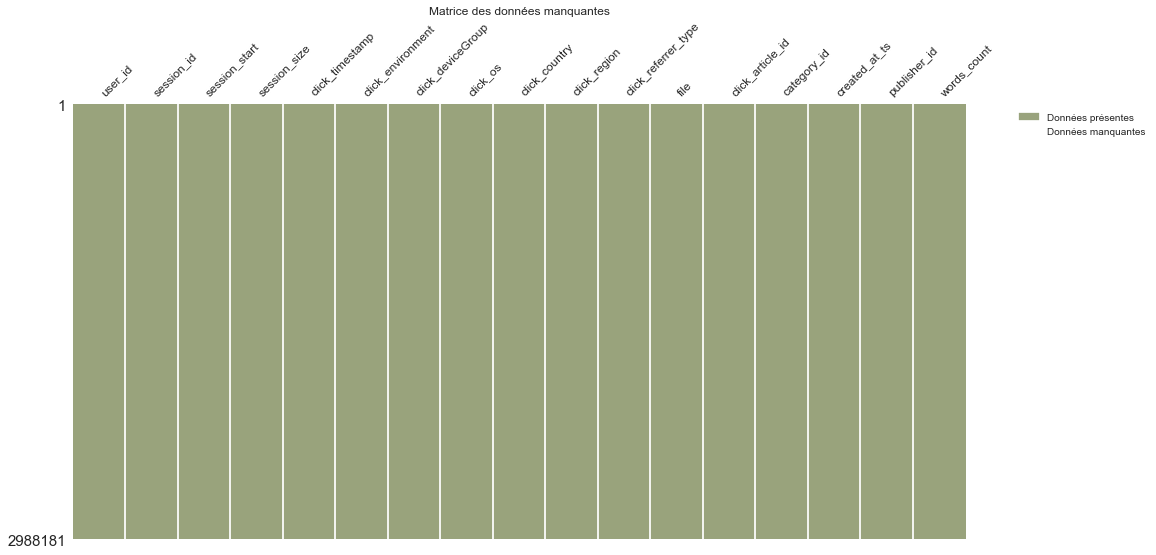

In [26]:
pk.matrix_vm(dfs, (16, 8), (0.60, 0.64, 0.49))

Aucune donnée manquante

### Création d'indicateurs

Créons des indicateurs comme le nombre de clicks par utilisateur et le nombre de clicks par utilisateur et par catégorie.

Commençons par le nombre de clicks par utilisateur

In [10]:
dfs_agg = pd.DataFrame( dfs.groupby(['user_id'])['click_article_id'].count().reset_index(name="total_click"))


In [29]:
dfs_agg

,user_id,total_click
0,0,8
1,1,12
2,2,4
3,3,17
4,4,7
...,...,...
322892,322892,2
322893,322893,2
322894,322894,2
322895,322895,2


Ajoutons à présent le nombre de clicks par catégorie et par utilisateur

In [11]:
dfs_agg_2 = pd.DataFrame(dfs.groupby(['user_id','category_id' ])['click_article_id'].count().reset_index(name="total_click_by_cat"))


In [31]:
dfs_agg_2

,user_id,category_id,total_click_by_cat
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1
...,...,...,...
1882297,322894,297,1
1882298,322895,133,1
1882299,322895,418,1
1882300,322896,26,1


In [12]:
dfs_agg_2.loc[dfs_agg_2["user_id"]==0]

,user_id,category_id,total_click_by_cat
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1
5,0,431,1


In [13]:
dfs_agg_3 = dfs_agg_2.join(dfs_agg, how='left', on='user_id', lsuffix="_1")

In [34]:
dfs_agg_3.loc[dfs_agg_3["user_id"]==0]

,user_id_1,category_id,total_click_by_cat,user_id,total_click
0,0,136,1,0,8
1,0,186,2,0,8
2,0,209,1,0,8
3,0,281,2,0,8
4,0,375,1,0,8
5,0,431,1,0,8


In [14]:
del dfs_agg_3["user_id_1"]

In [15]:
dfs_agg = dfs_agg_3.copy()

In [37]:
dfs_agg

,category_id,total_click_by_cat,user_id,total_click
0,136,1,0,8
1,186,2,0,8
2,209,1,0,8
3,281,2,0,8
4,375,1,0,8
...,...,...,...,...
1882297,297,1,322894,2
1882298,133,1,322895,2
1882299,418,1,322895,2
1882300,26,1,322896,2


Créons un taux en fonction du nombre de clicks par catégorie

In [16]:
dfs_agg['rating'] = dfs_agg['total_click_by_cat'] / dfs_agg['total_click']


In [39]:
dfs_agg.loc[dfs_agg["user_id"]==0]

,category_id,total_click_by_cat,user_id,total_click,rating
0,136,1,0,8,0.125
1,186,2,0,8,0.250
2,209,1,0,8,0.125
3,281,2,0,8,0.250
4,375,1,0,8,0.125
5,431,1,0,8,0.125


Maintenant que nous avons notre jeu de données, nous pouvons essayer d'en apprendre plus dessus.

## Exploration des données

### Statistiques descriptives

In [40]:
dfs_agg["category_id"].nunique()

316

Nous avons 316 catégories d'article qui ont été au moins cliqué par un utilisateur

In [41]:
dfs_agg["user_id"].nunique()

322897

Nous avons 322 897 utilisateurs qui ont au moins cliqué sur un article.

In [42]:
dfs_agg.describe()

,category_id,total_click_by_cat,user_id,total_click,rating
count,1.882302e+06,1.882302e+06,1.882302e+06,1.882302e+06,1.882302e+06
mean,3.016577e+02,1.587514e+00,1.205252e+05,2.289332e+01,1.715437e-01
std,1.191309e+02,1.921600e+00,8.726865e+04,3.391055e+01,1.844344e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,8.116883e-04
25%,2.470000e+02,1.000000e+00,4.710600e+04,6.000000e+00,4.761905e-02
50%,3.270000e+02,1.000000e+00,1.037510e+05,1.300000e+01,1.000000e-01
75%,4.090000e+02,2.000000e+00,1.837410e+05,2.800000e+01,2.307692e-01
max,4.600000e+02,5.350000e+02,3.228960e+05,1.232000e+03,1.000000e+00


Nous avons 322 897 d'utilisateurs. Ils ont fait en moyenne 22 clicks au total. 50% des utilisateurs ont fait plus de 13 clicks au total environs.<br>
Le nombre de click total en moyenne par catégorie est de 1.6 sachant que nous disposons de 316 catégories.

Vérifions s'il existe des valeurs aberrantes grâce à des nuages de point

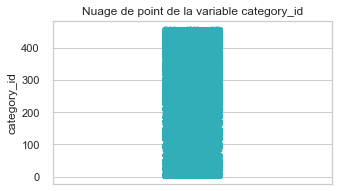

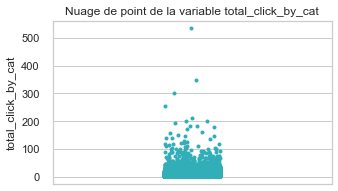

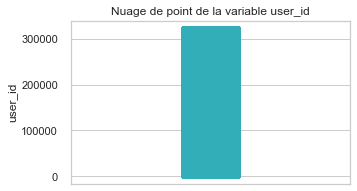

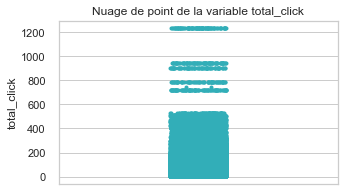

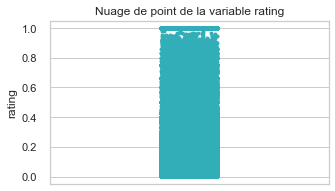

In [18]:
for col in dfs_agg.select_dtypes(include=['float64', 'int']).columns:
    pk.graph_stripplot(dfs_agg,col, "Nuage de point de la variable "+col,(5,3),"#32AEB8")

Nous observons quelques clicks important par rapport aux autres données,  mais cela reste raisonnable. <br>Traçons des boites à moustache pour avoir plus d'informations sur la dispersion des données au sein des variables

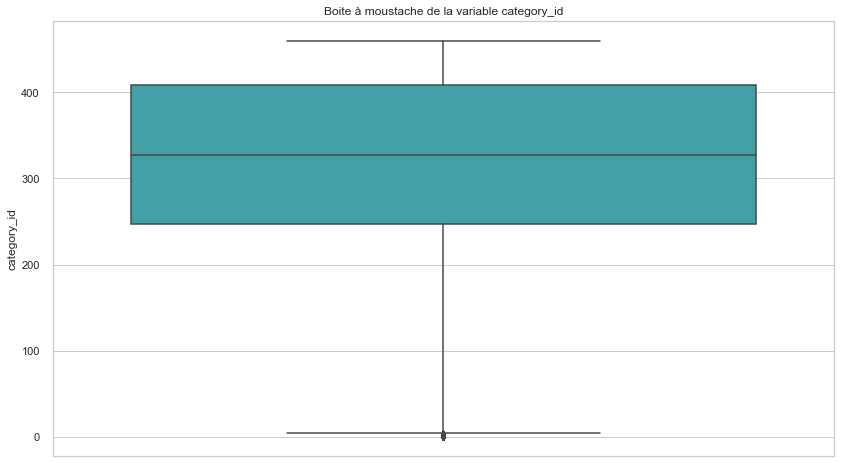

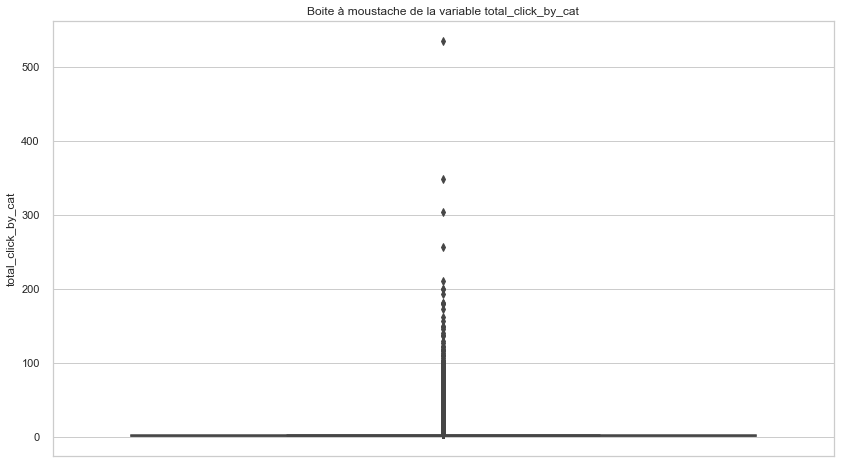

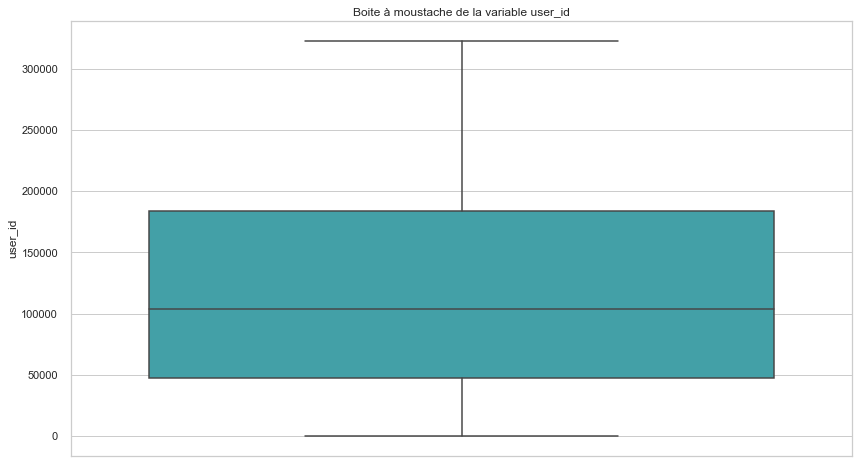

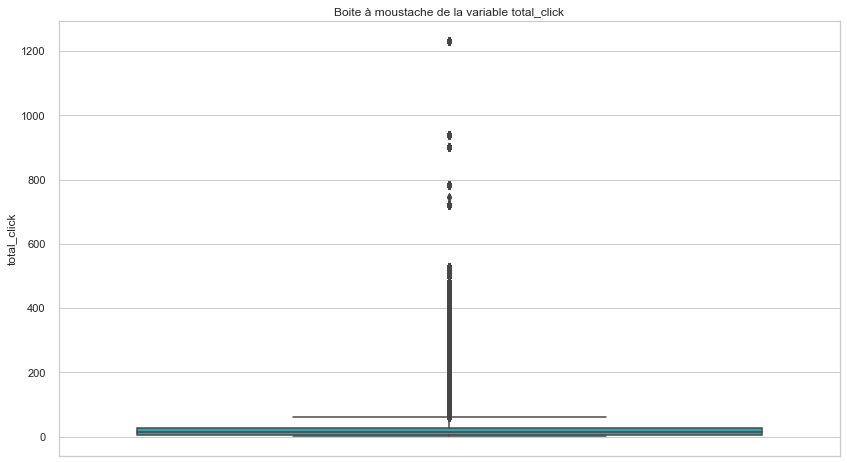

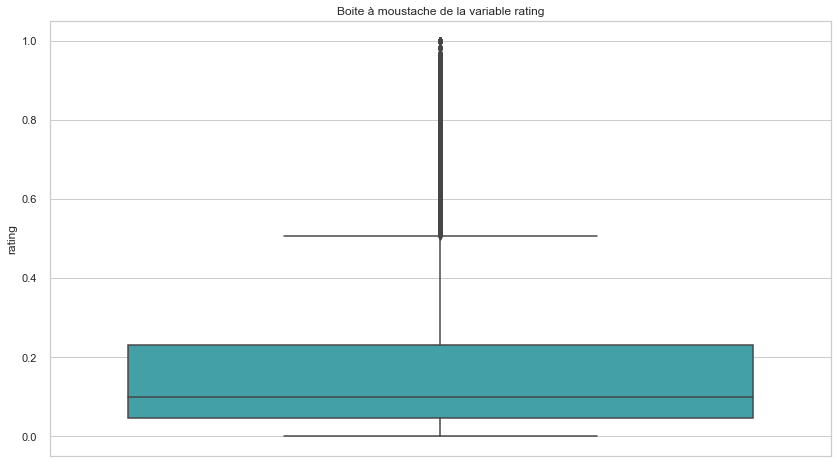

In [19]:
for col in dfs_agg.select_dtypes(include=['float64', 'int']).columns:
    pk.graph_boxplot(dfs_agg, col, "Boite à moustache de la variable "+col, "#32AEB8", (14,8))

Les données sont peu dispersées au sein de nos variables les boites sont plutôt aplaties. Il existe quelques valeurs extrêmes. Mais nous décidons de les conserver car elles semblent possible.

In [ ]:
dfs_agg.describe()

,total_click,user_id,category_id,total_click_by_cat,rating
count,322897.000000,322897.000000,322897.000000,322897.000000,322897.000000
mean,9.254285,14478.941093,298.650474,1.872575,0.483945
std,14.946358,8737.849175,119.283795,2.893215,1.030742
min,2.000000,0.000000,1.000000,1.000000,0.001111
25%,2.000000,6856.000000,231.000000,1.000000,0.125000
50%,4.000000,14229.000000,327.000000,1.000000,0.285714
75%,10.000000,22061.000000,409.000000,2.000000,0.500000
max,1232.000000,30279.000000,460.000000,535.000000,267.500000


Regardons la distribution de la variable total_click

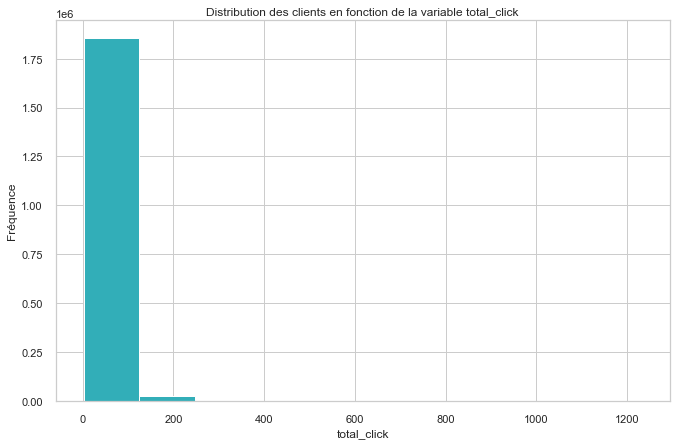

In [20]:
pk.graph_hist_interval_auto(dfs_agg['total_click'],
                                "Distribution des clients en fonction de la variable total_click",
                                "#32AEB8","total_click", "Fréquence")

La distribution est concentrée à gauche du graphique.

Etudions la distribution de la variable rating (le taux de clicks par catégorie des clients)

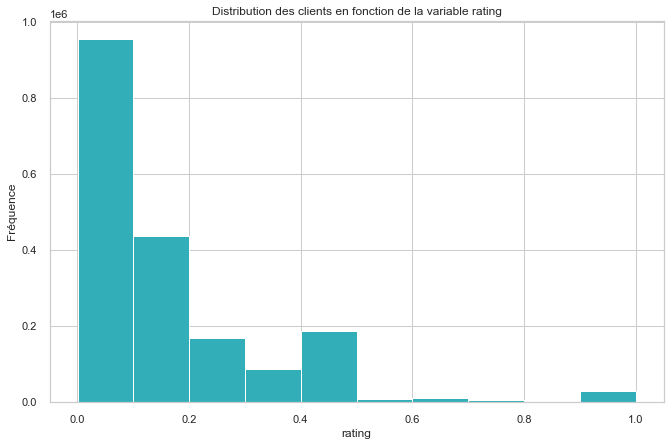

In [21]:
pk.graph_hist_interval_auto(dfs_agg['rating'],
                                "Distribution des clients en fonction de la variable rating",
                                "#32AEB8","rating", "Fréquence")

Nous observons que les clients regardent en général beaucoup de catégories différentes. En effet, plus de 80% des clients ont un taux de clicks entre 0 et 10%. 

Etudions les catégories les plus visitées par les utilisateurs.

In [ ]:
dfs_agg["category_id"].value_counts(normalize=True).head(20)

281    0.079034
375    0.065527
412    0.052364
437    0.048775
399    0.036973
250    0.035248
331    0.032025
209    0.029016
418    0.026094
323    0.024484
421    0.023483
118    0.022748
26     0.019889
409    0.019243
431    0.018379
136    0.018360
428    0.018346
442    0.017808
327    0.017589
301    0.016392
Name: category_id, dtype: float64

Les visites des utilisateurs semblent assez dispersées dans les catégories.

Faisons un regroupement.

In [43]:
info_lib=(dfs_agg["category_id"].value_counts(normalize=True)>=0.02)

In [44]:
info_lib.value_counts(normalize=True)

False    0.962025
True     0.037975
Name: category_id, dtype: float64

In [45]:
info_lib=list(info_lib.loc[info_lib== True].index)

In [46]:
def map_lib(lib):
    if lib in info_lib:
        return lib
    else:
        return "99"

In [47]:
dfs_agg["category_id_reg"]=dfs_agg["category_id"].map(map_lib, na_action=None)

In [48]:
dfs_agg["category_id_reg"].value_counts(normalize=True)

99     0.524230
281    0.079034
375    0.065527
412    0.052364
437    0.048775
399    0.036973
250    0.035248
331    0.032025
209    0.029016
418    0.026094
323    0.024484
421    0.023483
118    0.022748
Name: category_id_reg, dtype: float64

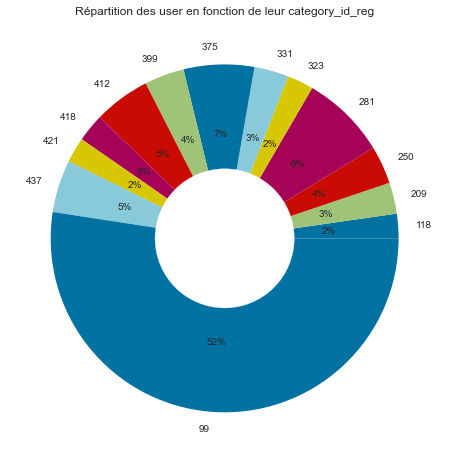

In [54]:
pk.graph_circle(dfs_agg["category_id_reg"], "category_id_reg", "Répartition des user en fonction de leur category_id_reg")

Les catégorie les plus visitées sont 375 et 281. En effet, la catégorie 375 est visitée par 7% des clients et la catégorie 281 par 8% des clients.

In [49]:
import gc

gc.collect()

4788

Maintenant que nous connaissons nos données, nous pouvons passer à la réalisation du système de recommandation.

## Système de recommandation

Il existe plusieurs types de recommandation dont :
- Content-based : le but est de suggérer des éléments similaires en fonction d'un élément particulier. Ce système utilise des métadonnées d'éléments, telles que le genre, l'auteur, la description etc. des livres, pour faire ces recommandations. L'idée générale derrière ces systèmes de recommandation est que si une personne aime un article particulier, elle aimera également un article qui lui est similaire. Et pour le recommander, il utilisera les métadonnées des éléments passés de l'utilisateur. 
- Collaborative filtered : ces systèmes sont largement utilisés et tentent de prédire la note ou la préférence qu'un utilisateur donnerait à un élément en fonction des notes et des préférences passées des autres utilisateurs. Les filtres collaboratifs ne nécessitent pas de métadonnées d'élément comme les systèmes basés sur le contenu.

Ici nous allons tester ces deux types de recommandation.

### Content based system recommendation

Nous allons utiliser ici l'embedding importé précédemment

In [43]:
art_embed.shape

(364047, 250)

Nous allons uniquement conserver les articles qui ont été cliqués au moins une fois.

In [46]:
arts = dfs["click_article_id"].value_counts().index

In [51]:
dfs["click_article_id"].value_counts()

160974    37213
272143    28943
336221    23851
234698    23499
123909    23122
          ...  
3306          1
166713        1
214721        1
350088        1
98243         1
Name: click_article_id, Length: 46033, dtype: int64

In [52]:
articles["click_article_id"].value_counts()

0         1
242727    1
242703    1
242702    1
242701    1
         ..
121347    1
121346    1
121345    1
121344    1
364046    1
Name: click_article_id, Length: 364047, dtype: int64

In [47]:
arts

Int64Index([160974, 272143, 336221, 234698, 123909, 336223,  96210, 162655,
            183176, 168623,
            ...
             15321, 296434, 296397, 350748, 106815,   3306, 166713, 214721,
            350088,  98243],
           dtype='int64', length=46033)

In [44]:
import gc

gc.collect()

468

In [55]:
articles["publisher_id"].nunique()

1

In [56]:
del articles["publisher_id"]

In [57]:
art_embed.shape

(364047, 250)

In [48]:
arts

Int64Index([160974, 272143, 336221, 234698, 123909, 336223,  96210, 162655,
            183176, 168623,
            ...
             15321, 296434, 296397, 350748, 106815,   3306, 166713, 214721,
            350088,  98243],
           dtype='int64', length=46033)

In [59]:
art_embed = art_embed[arts]
art_embed.shape

(46033, 250)

Pour réduire notre embedding, nous pouvons réaliser une ACP. En effet, sur Azure, il nous sera impossible d'importer gratuitement le fichier de base.

Essayons de visualiser nos données grâce à une analyse en composante principale. Ceci nous permettra de voir combien de dimensions il nous faudrait pour expliquer nos données. 

In [60]:
Z=pk_multi.amulti_acp_standard(art_embed)

250
[2.40739479e+01 1.78660774e+01 1.62346420e+01 1.33008299e+01
 1.07090616e+01 1.04431839e+01 8.69035149e+00 8.07654667e+00
 7.93012333e+00 6.87234879e+00 6.64398527e+00 6.41533279e+00
 5.87584305e+00 5.82609797e+00 5.18944168e+00 5.12258625e+00
 4.82030106e+00 4.36716795e+00 4.20207214e+00 4.00714922e+00
 3.85181713e+00 3.56260180e+00 3.46776319e+00 3.29411602e+00
 3.05131054e+00 2.96187019e+00 2.83383489e+00 2.61336112e+00
 2.46915364e+00 2.34730935e+00 2.30101132e+00 2.04780412e+00
 2.03015685e+00 1.88269591e+00 1.83394945e+00 1.73276639e+00
 1.66845810e+00 1.64226341e+00 1.55971181e+00 1.44403243e+00
 1.35433328e+00 1.31429684e+00 1.22606397e+00 1.10551155e+00
 1.08171523e+00 1.06757557e+00 9.94001567e-01 9.42357779e-01
 8.59958053e-01 8.31448615e-01 7.63228416e-01 7.08506942e-01
 6.54280603e-01 5.96485913e-01 5.90217650e-01 5.46654046e-01
 5.25260746e-01 4.72392857e-01 4.41375226e-01 4.07439679e-01
 3.52047831e-01 3.47139299e-01 3.13106179e-01 2.92558104e-01
 2.74097979e-01 2.54

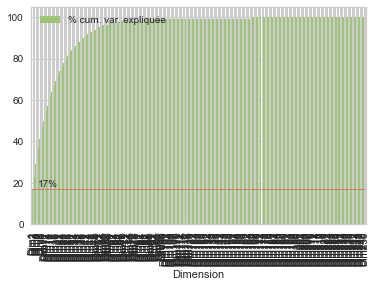

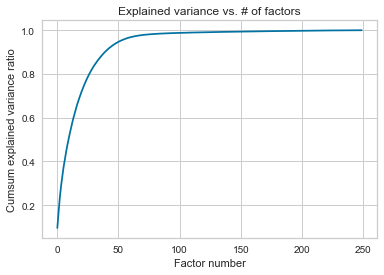

In [61]:
pk_multi.amulti_acp_choice_dim(art_embed, Z)

Il faudrait selon la méthode du coude, conserver 50 dimensions. Cependant, le fichier sera encore trop lourd pour Azure. Nous conservons donc 80% de la variance expliquée

In [62]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def amultiacp_visualizer_without_sticker(Z, dim):
    """
    Trace les graphiques pour visualiser les dimensions soit en 3d soit du premier plan factoriel
    
    Args:
        data_acp ([type]): données
        Z ([type]): données transformées
        dim([type]): nombre de dimensions retenues
        data_study([type]): toutes les données (qui contient les étiquettes)    
    """   
    pca = PCA(n_components=dim)
    #calculs
    WGI_pca = pca.fit_transform(Z)
    # Transformation en DataFrame pandas
    WGI_pca_df = pd.DataFrame({
        "Dim1" : WGI_pca[:,0], 
        "Dim2" : WGI_pca[:,1],
        "Dim3" : WGI_pca[:,2]
    })

    # Résultat (premières lignes)
    #WGI_pca_df.head()
    WGI_pca_df.plot.scatter("Dim1", "Dim2") # nuage de points
    plt.xlabel("Dimension 1 ") # modification du nom de l'axe X
    plt.ylabel("Dimension 2 ") # idem pour axe Y
    plt.suptitle("Premier plan factoriel") # titre général
    plt.show()
    
    ax = plt.figure(figsize=(16,10))
    ax = plt.axes(projection='3d')
    ax.scatter(
        xs=WGI_pca_df["Dim1"], 
        ys=WGI_pca_df["Dim2"], 
        zs=WGI_pca_df["Dim3"]
    )
    ax.set_xlabel('Dim 1 ')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    plt.show()
    return WGI_pca

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


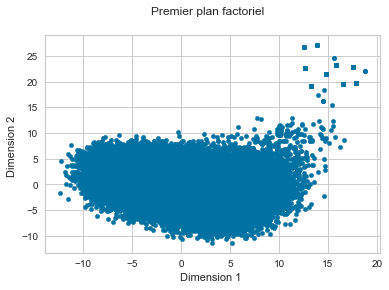

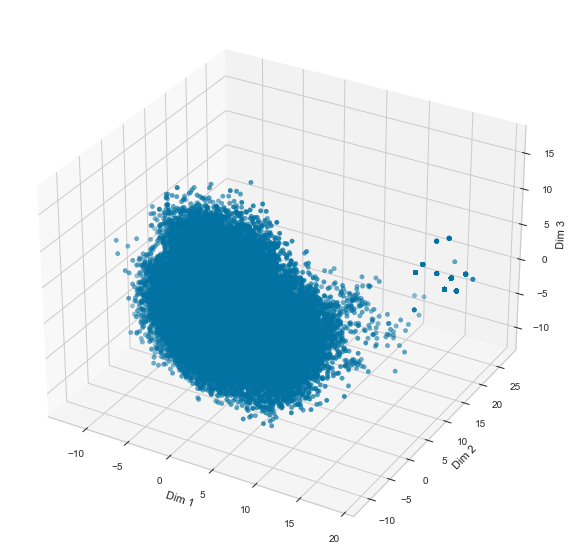

In [63]:
df_reduced = amultiacp_visualizer_without_sticker(Z, 0.80)

In [64]:
df_reduced.shape

(46033, 28)

In [65]:
df_reduced

array([[ 4.4098177 , -6.6391215 ,  0.9264275 , ...,  0.09995237,
         1.1843977 , -0.944156  ],
       [ 0.36574778, -1.0395323 , -5.7289834 , ..., -3.1537986 ,
        -0.30937946, -0.4867472 ],
       [ 1.9663274 , -0.41570544,  1.0472239 , ...,  2.9465492 ,
        -0.86912507, -0.1443288 ],
       ...,
       [ 3.5872054 , -4.1287723 ,  5.1783967 , ..., -0.15219103,
         1.8937479 , -1.25646   ],
       [-6.28472   , -2.794149  ,  1.3202729 , ..., -1.4334401 ,
         2.691557  ,  0.3305952 ],
       [18.77465   , 22.010057  ,  0.1623888 , ..., -0.44788945,
        -0.3230339 , -1.3871859 ]], dtype=float32)

Maintenant que nous avons notre réduction de données, nous pouvons faire les jointures avec les articles.

In [66]:
df_reduced_2 = pd.DataFrame(df_reduced)

In [67]:
df_reduced_2 = df_reduced_2.reset_index()

In [68]:
articles.shape

(364047, 4)

In [69]:
arts.shape

(46033,)

In [70]:
df_arts = pd.DataFrame(arts)

In [71]:
df_arts

,0
0,160974
1,272143
2,336221
3,234698
4,123909
...,...
46028,3306
46029,166713
46030,214721
46031,350088


In [72]:
df_arts = df_arts.reset_index()

In [73]:
df_arts.columns= ['index', 'article_id']

In [74]:
df_arts_embedd_acp = df_arts.join(df_reduced_2, how='left', on='index', lsuffix="_1")


In [75]:
del df_arts_embedd_acp["index_1"]

In [76]:
del df_arts_embedd_acp["index"]

In [77]:
gc.collect()

46685

In [78]:
df_arts_embedd_acp.head(2)

,article_id,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
0,160974,4.409818,-6.639122,0.926427,2.431026,0.762038,1.969448,-5.136955,-6.181464,0.567569,...,-1.453939,0.118815,0.335479,-0.070646,1.174920,-0.108625,-1.098951,0.099952,1.184398,-0.944156
1,272143,0.365748,-1.039532,-5.728983,1.457015,1.994284,-2.534556,1.640267,-0.554919,0.891390,...,-1.248821,5.384028,1.423406,2.994571,-0.059741,0.665796,0.391135,-3.153799,-0.309379,-0.486747


Sauvegardons nos données en csv pour l'import sous Azure.

In [80]:
#df_arts_embedd_acp.to_csv("Output\\data\\df_arts_embedd_acp_v2.csv")

In [5]:
import pandas as pd
import numpy as np

In [6]:
df_arts_embedd_acp = pd.read_csv("Output\\data\\df_arts_embedd_acp_v2.csv", dtype=np.float32)

In [8]:
df_arts_embedd_acp.head(2)

,Unnamed: 0,article_id,0,1,2,3,4,5,6,7,...,18,19,20,21,22,23,24,25,26,27
0,0.0,160974.0,4.409818,-6.639121,0.926427,2.431026,0.762038,1.969448,-5.136955,-6.181464,...,-1.453939,0.118815,0.335479,-0.070646,1.174920,-0.108625,-1.098951,0.099952,1.184398,-0.944156
1,1.0,272143.0,0.365748,-1.039532,-5.728983,1.457015,1.994284,-2.534556,1.640267,-0.554919,...,-1.248821,5.384028,1.423406,2.994571,-0.059741,0.665796,0.391135,-3.153799,-0.309379,-0.486747


In [9]:
del df_arts_embedd_acp["Unnamed: 0"]

In [10]:
arts_embedd_acp = df_arts_embedd_acp[[ '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27']].to_numpy(dtype = np.float32)

Nous créons une fonction pour récupérer un utilisateur

In [ ]:
dfs

,user_id,session_id,session_start,session_size,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,file,click_article_id,category_id,created_at_ts,publisher_id,words_count
0,0,1506825423271737,1506825423000,2,1506826828020,4,3,20,1,20,2,Input\clicks\clicks\clicks_hour_000.csv,157541,281,1506800518000,0,280
1,0,1506825423271737,1506825423000,2,1506826858020,4,3,20,1,20,2,Input\clicks\clicks\clicks_hour_000.csv,68866,136,1506816482000,0,226
2,1,1506825426267738,1506825426000,2,1506827017951,4,1,17,1,16,2,Input\clicks\clicks\clicks_hour_000.csv,235840,375,1506807839000,0,159
3,1,1506825426267738,1506825426000,2,1506827047951,4,1,17,1,16,2,Input\clicks\clicks\clicks_hour_000.csv,96663,209,1506788025000,0,206
4,2,1506825435299739,1506825435000,2,1506827090575,4,1,17,1,24,2,Input\clicks\clicks\clicks_hour_000.csv,119592,247,1506784316000,0,239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,1508211557302,4,3,2,1,25,1,Input\clicks\clicks\clicks_hour_384.csv,84911,174,1508187619000,0,171
2988177,322896,1508211376302329,1508211376000,2,1508211672520,4,1,17,1,25,2,Input\clicks\clicks\clicks_hour_384.csv,30760,26,1508185091000,0,162
2988178,322896,1508211376302329,1508211376000,2,1508211702520,4,1,17,1,25,2,Input\clicks\clicks\clicks_hour_384.csv,157507,281,1508236945000,0,370
2988179,123718,1508211379189330,1508211379000,2,1508211513583,4,3,2,1,25,2,Input\clicks\clicks\clicks_hour_384.csv,234481,375,1508181572000,0,212


In [94]:
#dfs.to_csv("Output\\data\\dfs.csv")

In [167]:
import pandas as pd

dfs = pd.read_csv("Output\\data\\dfs.csv")

In [168]:
dfs

,Unnamed: 0,user_id,session_id,session_start,session_size,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,file,click_article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1506825423271737,1506825423000,2,1506826828020,4,3,20,1,20,2,Input\clicks\clicks\clicks_hour_000.csv,157541,281,1506800518000,0,280
1,1,0,1506825423271737,1506825423000,2,1506826858020,4,3,20,1,20,2,Input\clicks\clicks\clicks_hour_000.csv,68866,136,1506816482000,0,226
2,2,1,1506825426267738,1506825426000,2,1506827017951,4,1,17,1,16,2,Input\clicks\clicks\clicks_hour_000.csv,235840,375,1506807839000,0,159
3,3,1,1506825426267738,1506825426000,2,1506827047951,4,1,17,1,16,2,Input\clicks\clicks\clicks_hour_000.csv,96663,209,1506788025000,0,206
4,4,2,1506825435299739,1506825435000,2,1506827090575,4,1,17,1,24,2,Input\clicks\clicks\clicks_hour_000.csv,119592,247,1506784316000,0,239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,2988176,10051,1508211372158328,1508211372000,2,1508211557302,4,3,2,1,25,1,Input\clicks\clicks\clicks_hour_384.csv,84911,174,1508187619000,0,171
2988177,2988177,322896,1508211376302329,1508211376000,2,1508211672520,4,1,17,1,25,2,Input\clicks\clicks\clicks_hour_384.csv,30760,26,1508185091000,0,162
2988178,2988178,322896,1508211376302329,1508211376000,2,1508211702520,4,1,17,1,25,2,Input\clicks\clicks\clicks_hour_384.csv,157507,281,1508236945000,0,370
2988179,2988179,123718,1508211379189330,1508211379000,2,1508211513583,4,3,2,1,25,2,Input\clicks\clicks\clicks_hour_384.csv,234481,375,1508181572000,0,212


In [174]:
dfs = dfs[["user_id", "click_article_id"]]

In [178]:
dfs.to_csv("Output\\data\\dfs_v2.csv")

In [83]:
dfs["click_article_id"].value_counts()

160974    37213
272143    28943
336221    23851
234698    23499
123909    23122
          ...  
3306          1
166713        1
214721        1
350088        1
98243         1
Name: click_article_id, Length: 46033, dtype: int64

In [84]:
arts = dfs["click_article_id"].value_counts().index

In [85]:
arts

Int64Index([160974, 272143, 336221, 234698, 123909, 336223,  96210, 162655,
            183176, 168623,
            ...
             15321, 296434, 296397, 350748, 106815,   3306, 166713, 214721,
            350088,  98243],
           dtype='int64', length=46033)

In [176]:
dfs_user_art = dfs.groupby(["user_id", "click_article_id"])["click_article_id"].count().reset_index(name="nb_click_by_arts")

In [177]:
dfs_user_art[dfs_user_art["user_id"]==0]

,user_id,click_article_id,nb_click_by_arts
0,0,68866,1
1,0,87205,1
2,0,87224,1
3,0,96755,1
4,0,157541,1
5,0,160158,1
6,0,233470,1
7,0,313996,1


In [87]:
#dfs_user_art.to_csv("Output\\data\\dfs_user_art.csv")

In [88]:
dfs_user_art = pd.read_csv("Output\\data\\dfs_user_art.csv")

In [ ]:
gc.collect()

In [89]:
import gc
gc.collect()

1407

In [90]:
def user(x):
    user = dfs_user_art.loc[dfs_user_art['user_id']==x]
    if len(user)>0:
        return user
    return np.nan

In [91]:
test = user(10)

Nous calculons à présent la similarité avec le cosinus.

In [92]:
gc.collect()

0

In [20]:
df_arts_embedd_acp.shape

(46033, 30)

In [21]:
df_arts_embedd_acp

,Unnamed: 0,article_id,0,1,2,3,4,5,6,7,...,18,19,20,21,22,23,24,25,26,27
0,0.0,160974.0,4.409818,-6.639122,0.926427,2.431026,0.762038,1.969448,-5.136955,-6.181464,...,-1.453939,0.118815,0.335479,-0.070646,1.174920,-0.108625,-1.098951,0.099952,1.184398,-0.944156
1,1.0,272143.0,0.365748,-1.039532,-5.728983,1.457015,1.994284,-2.534556,1.640267,-0.554919,...,-1.248821,5.384028,1.423406,2.994571,-0.059741,0.665796,0.391135,-3.153799,-0.309379,-0.486747
2,2.0,336221.0,1.966327,-0.415705,1.047224,-7.377117,1.946469,-7.320769,2.086489,-0.853537,...,-3.561550,2.487598,2.985157,-1.030350,-0.614082,-1.822304,-1.391730,2.946549,-0.869125,-0.144329
3,3.0,234698.0,2.178805,-5.133606,0.382549,2.705868,0.959321,-2.768934,1.368384,-6.675447,...,0.066011,1.693189,-0.677566,0.439447,0.272845,2.698020,-0.082876,-3.704268,1.153967,1.460297
4,4.0,123909.0,-4.758974,3.375851,-5.330550,0.963728,0.857619,-2.149371,-4.398415,1.647194,...,0.676664,-2.375500,0.155846,-2.247731,2.054658,0.100919,-1.886052,-0.242966,-2.032787,-0.883262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46028,46028.0,3306.0,-7.646194,-1.915921,-2.415429,2.103166,-2.557936,1.708440,-0.197465,-6.371129,...,1.719261,1.068312,-0.154430,-1.334877,-2.746202,-1.773311,-1.291318,4.831487,2.185073,0.197575
46029,46029.0,166713.0,3.677934,-0.110976,3.636587,9.289109,4.806588,-6.590909,-3.193905,-1.679668,...,3.856145,0.613967,1.000408,3.482371,2.995691,-1.207539,1.161455,-1.122588,1.472571,3.353741
46030,46030.0,214721.0,3.587205,-4.128772,5.178397,1.385262,-1.710381,-2.418609,-0.360348,-6.810805,...,-0.495343,1.340402,-1.129253,-0.415873,0.046289,1.978081,1.154006,-0.152191,1.893748,-1.256460
46031,46031.0,350088.0,-6.284720,-2.794149,1.320273,2.022784,-2.384351,0.463877,0.921245,3.341046,...,-3.389887,-1.733202,-1.714559,2.399443,1.506086,3.524483,3.214269,-1.433440,2.691557,0.330595


In [22]:
arts_embedd_acp = df_arts_embedd_acp.iloc[:, 1:]

In [23]:
gc.collect()

0

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(arts_embedd_acp, arts_embedd_acp)
#cosine_sim[:4, :4]

In [29]:
import gc
gc.collect()

21

In [24]:
arts_embedd_acp

,article_id,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
0,160974.0,4.409818,-6.639122,0.926427,2.431026,0.762038,1.969448,-5.136955,-6.181464,0.567569,...,-1.453939,0.118815,0.335479,-0.070646,1.174920,-0.108625,-1.098951,0.099952,1.184398,-0.944156
1,272143.0,0.365748,-1.039532,-5.728983,1.457015,1.994284,-2.534556,1.640267,-0.554919,0.891390,...,-1.248821,5.384028,1.423406,2.994571,-0.059741,0.665796,0.391135,-3.153799,-0.309379,-0.486747
2,336221.0,1.966327,-0.415705,1.047224,-7.377117,1.946469,-7.320769,2.086489,-0.853537,-5.539290,...,-3.561550,2.487598,2.985157,-1.030350,-0.614082,-1.822304,-1.391730,2.946549,-0.869125,-0.144329
3,234698.0,2.178805,-5.133606,0.382549,2.705868,0.959321,-2.768934,1.368384,-6.675447,0.233952,...,0.066011,1.693189,-0.677566,0.439447,0.272845,2.698020,-0.082876,-3.704268,1.153967,1.460297
4,123909.0,-4.758974,3.375851,-5.330550,0.963728,0.857619,-2.149371,-4.398415,1.647194,2.808233,...,0.676664,-2.375500,0.155846,-2.247731,2.054658,0.100919,-1.886052,-0.242966,-2.032787,-0.883262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46028,3306.0,-7.646194,-1.915921,-2.415429,2.103166,-2.557936,1.708440,-0.197465,-6.371129,0.587404,...,1.719261,1.068312,-0.154430,-1.334877,-2.746202,-1.773311,-1.291318,4.831487,2.185073,0.197575
46029,166713.0,3.677934,-0.110976,3.636587,9.289109,4.806588,-6.590909,-3.193905,-1.679668,0.555964,...,3.856145,0.613967,1.000408,3.482371,2.995691,-1.207539,1.161455,-1.122588,1.472571,3.353741
46030,214721.0,3.587205,-4.128772,5.178397,1.385262,-1.710381,-2.418609,-0.360348,-6.810805,2.413965,...,-0.495343,1.340402,-1.129253,-0.415873,0.046289,1.978081,1.154006,-0.152191,1.893748,-1.256460
46031,350088.0,-6.284720,-2.794149,1.320273,2.022784,-2.384351,0.463877,0.921245,3.341046,-0.753224,...,-3.389887,-1.733202,-1.714559,2.399443,1.506086,3.524483,3.214269,-1.433440,2.691557,0.330595


In [25]:
user_arts = user(0)

In [40]:
user_arts

,Unnamed: 0,user_id,click_article_id,nb_click_by_arts
0,0,0,68866,1
1,1,0,87205,1
2,2,0,87224,1
3,3,0,96755,1
4,4,0,157541,1
5,5,0,160158,1
6,6,0,233470,1
7,7,0,313996,1


In [41]:
test = pd.DataFrame(user_arts["click_article_id"])

In [44]:
test.columns= ["article_id"]

In [45]:
test

,article_id
0,68866
1,87205
2,87224
3,96755
4,157541
5,160158
6,233470
7,313996


In [46]:
test2 = df_arts_embedd_acp.merge(test, how='inner', on='article_id')

In [47]:
test2

,Unnamed: 0,article_id,0,1,2,3,4,5,6,7,...,18,19,20,21,22,23,24,25,26,27
0,91.0,96755.0,0.561682,-0.275829,-2.484952,2.326820,1.080367,4.866472,-5.229543,-5.192376,...,0.329746,-3.478764,-1.051035,2.468488,3.284795,2.057707,-2.195386,-0.527600,1.366029,-0.916289
1,118.0,87224.0,12.974573,-0.266871,-0.086326,-6.449033,1.612581,-3.143589,2.005225,2.320927,...,-0.062828,0.491927,1.320311,-0.279294,1.075975,1.310596,0.850697,0.731010,-1.016009,0.695753
2,151.0,313996.0,-2.867847,0.503823,6.272486,-7.839911,1.613139,2.343978,-1.711982,-0.474289,...,1.224098,-0.191985,-3.733354,-1.048811,-2.833148,2.884380,0.941439,-1.637126,1.563002,-1.991673
3,342.0,160158.0,6.480545,-4.083380,0.654248,3.155655,-0.659966,-1.529571,-2.350570,-4.173399,...,-2.227591,-2.171608,2.059141,0.832706,0.577733,-0.005742,1.812651,1.363653,2.524569,1.498322
4,390.0,68866.0,3.240392,-6.334606,-0.932952,0.314616,0.613342,3.718720,-3.099787,-4.327018,...,-0.148392,0.577484,-1.184876,-0.828646,1.047456,-1.020450,-2.041848,1.647254,0.808552,-0.696717
5,415.0,87205.0,8.862714,2.397000,-2.525647,-4.071080,-0.864252,-4.617552,-2.782691,-1.040644,...,-0.404056,-0.551660,2.075271,0.000668,-0.348166,0.626063,0.927877,-0.331128,-3.277478,-1.555419
6,649.0,233470.0,-2.835145,-5.281062,-7.043384,-0.512602,2.296744,-1.142827,-2.962854,-0.268313,...,1.899525,1.989843,-1.258359,0.170512,-0.615520,0.752602,0.211670,-0.483292,-0.921171,0.454838
7,1044.0,157541.0,3.682675,-9.746256,0.149198,1.933824,-0.341727,3.407132,-2.794782,-6.286205,...,-0.623213,-2.712119,-1.166157,1.074452,1.527807,0.549764,-0.986087,2.266890,1.245560,-1.567333


In [30]:
df_arts_embedd_acp

,Unnamed: 0,article_id,0,1,2,3,4,5,6,7,...,18,19,20,21,22,23,24,25,26,27
0,0.0,160974.0,4.409818,-6.639122,0.926427,2.431026,0.762038,1.969448,-5.136955,-6.181464,...,-1.453939,0.118815,0.335479,-0.070646,1.174920,-0.108625,-1.098951,0.099952,1.184398,-0.944156
1,1.0,272143.0,0.365748,-1.039532,-5.728983,1.457015,1.994284,-2.534556,1.640267,-0.554919,...,-1.248821,5.384028,1.423406,2.994571,-0.059741,0.665796,0.391135,-3.153799,-0.309379,-0.486747
2,2.0,336221.0,1.966327,-0.415705,1.047224,-7.377117,1.946469,-7.320769,2.086489,-0.853537,...,-3.561550,2.487598,2.985157,-1.030350,-0.614082,-1.822304,-1.391730,2.946549,-0.869125,-0.144329
3,3.0,234698.0,2.178805,-5.133606,0.382549,2.705868,0.959321,-2.768934,1.368384,-6.675447,...,0.066011,1.693189,-0.677566,0.439447,0.272845,2.698020,-0.082876,-3.704268,1.153967,1.460297
4,4.0,123909.0,-4.758974,3.375851,-5.330550,0.963728,0.857619,-2.149371,-4.398415,1.647194,...,0.676664,-2.375500,0.155846,-2.247731,2.054658,0.100919,-1.886052,-0.242966,-2.032787,-0.883262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46028,46028.0,3306.0,-7.646194,-1.915921,-2.415429,2.103166,-2.557936,1.708440,-0.197465,-6.371129,...,1.719261,1.068312,-0.154430,-1.334877,-2.746202,-1.773311,-1.291318,4.831487,2.185073,0.197575
46029,46029.0,166713.0,3.677934,-0.110976,3.636587,9.289109,4.806588,-6.590909,-3.193905,-1.679668,...,3.856145,0.613967,1.000408,3.482371,2.995691,-1.207539,1.161455,-1.122588,1.472571,3.353741
46030,46030.0,214721.0,3.587205,-4.128772,5.178397,1.385262,-1.710381,-2.418609,-0.360348,-6.810805,...,-0.495343,1.340402,-1.129253,-0.415873,0.046289,1.978081,1.154006,-0.152191,1.893748,-1.256460
46031,46031.0,350088.0,-6.284720,-2.794149,1.320273,2.022784,-2.384351,0.463877,0.921245,3.341046,...,-3.389887,-1.733202,-1.714559,2.399443,1.506086,3.524483,3.214269,-1.433440,2.691557,0.330595


In [48]:
arts_embedd_acp = df_arts_embedd_acp[[ '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27']].to_numpy(dtype = np.float32)
       #, '28', '29', '30', '31', '32', '33', '34',
       #'35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       #'47', '48', '49', '50', '51']]

In [51]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(arts_embedd_acp_user,arts_embedd_acp, dense_output=False)
#cosine_sim[:4, :4]

In [52]:
import gc

gc.collect()

1169

In [53]:
cosine_sim.shape

(8, 46033)

In [54]:
cosine_sim

array([[ 0.29881242, -0.14770515, -0.2578657 , ..., -0.04702142,
         0.00357909,  0.00551729],
       [ 0.0409651 ,  0.04564605,  0.42561138, ...,  0.03602111,
        -0.400014  ,  0.31663114],
       [ 0.05634588, -0.20332658,  0.09772368, ...,  0.10245783,
         0.02738835, -0.19475408],
       ...,
       [ 0.14376326,  0.30550078,  0.12916481, ...,  0.07079153,
        -0.58892393,  0.32997322],
       [ 0.09270505,  0.17946696, -0.01115231, ..., -0.03619114,
         0.1612081 , -0.430581  ],
       [ 0.8637879 ,  0.06300095, -0.04006108, ...,  0.59757257,
        -0.02668777, -0.20483032]], dtype=float32)

Maintenant que nous avons notre matrice de similarité, nous pouvons calculer les articles recommandés.

In [62]:
sim_scores = sorted(cosine_sim, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:6]

In [ ]:
dfs_user_art['click_article_id'].shape

(2950710,)

In [128]:
arts = pd.DataFrame(arts)

In [28]:
arts

Int64Index([160974, 272143, 336221, 234698, 123909, 336223,  96210, 162655,
            183176, 168623,
            ...
             15321, 296434, 296397, 350748, 106815,   3306, 166713, 214721,
            350088,  98243],
           dtype='int64', length=46033)

In [70]:
titles = test2['article_id']
indices = pd.Series(range(0,8), index=titles)

In [76]:
len(titles)

8

In [71]:
indices

article_id
96755.0     0
87224.0     1
313996.0    2
160158.0    3
68866.0     4
87205.0     5
233470.0    6
157541.0    7
dtype: int64

In [57]:
gc.collect()

0

In [37]:
cosine_sim.shape

(46033, 46033)

Livre recommandé

In [72]:
def arts_recommendations(x):
    idx = indices[x]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return sim_scores#x.iloc[movie_indices]

Livres recommandés par user

In [78]:
def user_recommendation(x):
    reco = []
    user_arts = user(x)
    for art in user_arts["click_article_id"]:
        livre = arts_recommendations(art)
        reco.append(livre[0])
    sim_scores = sorted(reco, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    return sim_scores

Test d'un user

In [44]:
user_recommendation(0)

[(36168, 0.9336822),
 (22832, 0.92724484),
 (36326, 0.91790175),
 (23140, 0.91421944),
 (2247, 0.87370986)]

In [147]:
gc.collect()

7

In [94]:
result = user_recommendation(0)

Essayons de passer nos résultats en json pour que la création de notre azure fonction aille plus vite.

In [116]:
json_result = []
for i in result:
    json_result.append({"article_id":i[0], "cosine_similarity":str(i[1])})


In [ ]:
import json
jsonStr = json.dumps(json_result)

In [118]:
print(jsonStr)

[{"article_id": 36168, "cosine_similarity": "0.9336822"}, {"article_id": 22832, "cosine_similarity": "0.92724484"}, {"article_id": 36326, "cosine_similarity": "0.91790175"}, {"article_id": 23140, "cosine_similarity": "0.91421944"}, {"article_id": 2247, "cosine_similarity": "0.87371"}]


Nous avons pu facilement réaliser un algorithme afin d'obtenir des recommandations par utilisateur basé sur le contenu. Passons à une méthode plus poussé avec l'utilisation de modèle : le filtering collaborative

###  Collaborative Filtering

Nous allons comparer deux modèles : SVD et NMF.

SVD : L'un des systèmes de recommandation les plus puissants est le modèle SVD. SVD est une forme de factorisation matricielle qui utilise la descente de gradient pour créer des prédictions pour les notes des utilisateurs, tout en minimisant l'erreur entre les notes prédites et les notes réelles de notre matrice d'utilité d'origine. En conséquence, la descente de gradient minimise la RMSE lors de la prédiction de ces nouvelles notes.

NMF :  NMF est assez similaire à SVD sauf que nous allons chercher les matrices avec des nombres supérieur à 0, autrement dit nous recherchons une matrice de factorisation non-negative.

In [ ]:
dfs_user_art.head(2)

,user_id,click_article_id,nb_click_by_arts
0,0,68866,1
1,0,87205,1


In [ ]:
dfs_user_art

,user_id,click_article_id,nb_click_by_arts
0,0,68866,1
1,0,87205,1
2,0,87224,1
3,0,96755,1
4,0,157541,1
...,...,...,...
2950705,322894,168401,1
2950706,322895,63746,1
2950707,322895,289197,1
2950708,322896,30760,1


In [24]:
articles.column = ["click_article_id", "category_id", "created_at_ts", "words_count"]

C:\Users\aurel\AppData\Local\Temp\ipykernel_20736\2005646722.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  articles.column = ["click_article_id", "category_id", "created_at_ts", "words_count"]


In [25]:
dfs_agg_info = dfs_user_art.join(articles, how='left', on='click_article_id', lsuffix="_1")

In [26]:
dfs_agg_info

,Unnamed: 0,user_id,click_article_id_1,nb_click_by_arts,click_article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,68866,1,68866,136,1506816482000,0,226
1,1,0,87205,1,87205,186,1507497786000,0,137
2,2,0,87224,1,87224,186,1507496527000,0,100
3,3,0,96755,1,96755,209,1507326628000,0,211
4,4,0,157541,1,157541,281,1506800518000,0,280
...,...,...,...,...,...,...,...,...,...
2950705,2950705,322894,168401,1,168401,297,1507663321000,0,215
2950706,2950706,322895,63746,1,63746,133,1508142585000,0,162
2950707,2950707,322895,289197,1,289197,418,1508179909000,0,176
2950708,2950708,322896,30760,1,30760,26,1508185091000,0,162


In [27]:
total_click = dfs_agg[["user_id", "category_id", "rating" ,"total_click"]].drop_duplicates()

In [28]:
total_click.column = ["user_id", "category_id", "rating_cat" ,"total_click"]

C:\Users\aurel\AppData\Local\Temp\ipykernel_20736\574683373.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  total_click.column = ["user_id", "category_id", "rating_cat" ,"total_click"]


In [29]:
total_click

,user_id,category_id,rating,total_click
0,0,136,0.125,8
1,0,186,0.250,8
2,0,209,0.125,8
3,0,281,0.250,8
4,0,375,0.125,8
...,...,...,...,...
1882297,322894,297,0.500,2
1882298,322895,133,0.500,2
1882299,322895,418,0.500,2
1882300,322896,26,0.500,2


In [30]:
dfs_agg_info_2 = dfs_agg_info.merge(total_click, how='left', on=["user_id", 'category_id'])

In [31]:
dfs_agg_info.shape

(2950710, 9)

In [32]:
dfs_agg_info_2.shape

(2950710, 11)

In [33]:
dfs_agg_info_2.loc[dfs_agg_info_2["user_id"]==0]

,Unnamed: 0,user_id,click_article_id_1,nb_click_by_arts,click_article_id,category_id,created_at_ts,publisher_id,words_count,rating,total_click
0,0,0,68866,1,68866,136,1506816482000,0,226,0.125,8
1,1,0,87205,1,87205,186,1507497786000,0,137,0.250,8
2,2,0,87224,1,87224,186,1507496527000,0,100,0.250,8
3,3,0,96755,1,96755,209,1507326628000,0,211,0.125,8
4,4,0,157541,1,157541,281,1506800518000,0,280,0.250,8
5,5,0,160158,1,160158,281,1507352746000,0,145,0.250,8
6,6,0,233470,1,233470,375,1507375559000,0,292,0.125,8
7,7,0,313996,1,313996,431,1507317197000,0,265,0.125,8


In [34]:
del dfs_agg_info_2["click_article_id_1"]

In [35]:
del dfs_agg_info_2["created_at_ts"]

In [36]:
dfs_agg_info_2.loc[dfs_agg_info_2["user_id"]==0]

,Unnamed: 0,user_id,nb_click_by_arts,click_article_id,category_id,publisher_id,words_count,rating,total_click
0,0,0,1,68866,136,0,226,0.125,8
1,1,0,1,87205,186,0,137,0.250,8
2,2,0,1,87224,186,0,100,0.250,8
3,3,0,1,96755,209,0,211,0.125,8
4,4,0,1,157541,281,0,280,0.250,8
5,5,0,1,160158,281,0,145,0.250,8
6,6,0,1,233470,375,0,292,0.125,8
7,7,0,1,313996,431,0,265,0.125,8


In [37]:
dfs_agg_info_2['rating_art'] = dfs_agg_info_2['nb_click_by_arts'] / dfs_agg_info_2['total_click']

In [38]:
dfs_agg_info_2

,Unnamed: 0,user_id,nb_click_by_arts,click_article_id,category_id,publisher_id,words_count,rating,total_click,rating_art
0,0,0,1,68866,136,0,226,0.125,8,0.125
1,1,0,1,87205,186,0,137,0.250,8,0.125
2,2,0,1,87224,186,0,100,0.250,8,0.125
3,3,0,1,96755,209,0,211,0.125,8,0.125
4,4,0,1,157541,281,0,280,0.250,8,0.125
...,...,...,...,...,...,...,...,...,...,...
2950705,2950705,322894,1,168401,297,0,215,0.500,2,0.500
2950706,2950706,322895,1,63746,133,0,162,0.500,2,0.500
2950707,2950707,322895,1,289197,418,0,176,0.500,2,0.500
2950708,2950708,322896,1,30760,26,0,162,0.500,2,0.500


Préparons nos données pour utiliser le framework surprise.

In [63]:
from surprise import Reader, Dataset

reader = Reader()
data = Dataset.load_from_df(dfs_agg_info_2[['user_id', 'click_article_id', 'rating']], reader)

In [40]:
dfs_agg_info_2.shape

(2950710, 10)

Créons un pipeline pour comparer les deux modèles et choisir celui qui est plus adapté à nos données.
Nous intégrons aussi la cross validation et utilisons l'écart quadratique moyen. Cette métrique correspond à l'écart entre les prévisions et les points de données (écart-type des résidus)

In [41]:
from surprise import SVD, NMF
from surprise.model_selection import cross_validate

benchmark = []
# Iterate over all algorithms

algorithms = [SVD(), NMF()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=10, verbose=False)
    # results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x00000199362CEE80>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x00000199362CEE20>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x00000199362CEE80>


C:\Users\aurel\AppData\Local\Temp\ipykernel_20736\2524002951.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x00000199362CEE80> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x00000199362CEE20>
Done:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x00000199362CEE20> 



	DONE



C:\Users\aurel\AppData\Local\Temp\ipykernel_20736\2524002951.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


In [42]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [43]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.825046,157.574204,3.609749
NMF,0.825051,184.624731,2.941392


Nous observons que SVD est le meilleur compromis en terme de RMSE et de temps.

In [106]:
gc.collect()

977

In [45]:
from surprise.model_selection import GridSearchCV
from surprise import SVD, NMF
from surprise.model_selection import cross_validate


Recherchons à présent les meilleurs paramètres pour SVD, utilisons gridSearchCV

In [46]:

# smaller grid for testing
param_grid = {
    "n_epochs": [10, 20],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.02]
}

gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], refit=True, cv=5)

gs.fit(data)

training_parameters = gs.best_params["rmse"]

print("BEST RMSE: \t", gs.best_score["rmse"])
print("BEST MAE: \t", gs.best_score["mae"])
print("BEST params: \t", gs.best_params["rmse"])

BEST RMSE: 	 0.8250429000537356
BEST MAE: 	 0.798000737694243
BEST params: 	 {'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.02}


Nous pouvons entrainer notre modèle avec ces paramètres

In [47]:
from datetime import datetime

print(training_parameters)
reader = Reader(rating_scale=(1, 5))

print("\n\n\t\t STARTING\n\n")
start = datetime.now()

print("> Loading data...")
data = Dataset.load_from_df(dfs_agg[['user_id', 'category_id', 'rating']], reader)
print("> OK")

print("> Creating trainset...")
trainset = data.build_full_trainset()
print("> OK")


startTraining = datetime.now()
print("> Training...")

algo = SVD(n_epochs = training_parameters['n_epochs'], lr_all = training_parameters['lr_all'], reg_all = training_parameters['reg_all'])

algo.fit(trainset)

endTraining = datetime.now()
print("> OK \t\t It Took: ", (endTraining-startTraining).seconds, "seconds")

end = datetime.now()
print (">> DONE \t\t It Took", (end-start).seconds, "seconds" )

{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.02}


		 STARTING


> Loading data...
> OK
> Creating trainset...
> OK
> Training...
> OK 		 It Took:  47 seconds
>> DONE 		 It Took 51 seconds


Nous pouvons à présent réaliser un test de prédiction.

In [48]:
trainSet = data.build_full_trainset()

In [49]:
trainSet

In [50]:
anti_testset_user = []
targetUser = 0 #inner_id of the target user
fillValue = trainSet.global_mean
user_item_ratings = trainSet.ur[targetUser]
user_items = [item for (item,_) in (user_item_ratings)]
user_items
ratings = trainSet.all_ratings()
for iid in trainSet.all_items():
  if(iid not in user_items):
    anti_testset_user.append((trainSet.to_raw_uid(targetUser),trainSet.to_raw_iid(iid),fillValue))

In [51]:
anti_testset_user

[(0, 43, 0.1715436736506681),
 (0, 123, 0.1715436736506681),
 (0, 301, 0.1715436736506681),
 (0, 331, 0.1715436736506681),
 (0, 412, 0.1715436736506681),
 (0, 435, 0.1715436736506681),
 (0, 26, 0.1715436736506681),
 (0, 247, 0.1715436736506681),
 (0, 332, 0.1715436736506681),
 (0, 249, 0.1715436736506681),
 (0, 421, 0.1715436736506681),
 (0, 81, 0.1715436736506681),
 (0, 92, 0.1715436736506681),
 (0, 132, 0.1715436736506681),
 (0, 317, 0.1715436736506681),
 (0, 399, 0.1715436736506681),
 (0, 437, 0.1715436736506681),
 (0, 67, 0.1715436736506681),
 (0, 99, 0.1715436736506681),
 (0, 118, 0.1715436736506681),
 (0, 125, 0.1715436736506681),
 (0, 126, 0.1715436736506681),
 (0, 127, 0.1715436736506681),
 (0, 135, 0.1715436736506681),
 (0, 137, 0.1715436736506681),
 (0, 138, 0.1715436736506681),
 (0, 250, 0.1715436736506681),
 (0, 276, 0.1715436736506681),
 (0, 297, 0.1715436736506681),
 (0, 299, 0.1715436736506681),
 (0, 327, 0.1715436736506681),
 (0, 354, 0.1715436736506681),
 (0, 409, 0.17

In [52]:
predictions = algo.test(anti_testset_user)

In [53]:
predictions[0]

Prediction(uid=0, iid=43, r_ui=0.1715436736506681, est=1, details={'was_impossible': False})

In [ ]:
pred = pd.DataFrame(predictions)
pred.sort_values(by=['est'],inplace=True,ascending = False)
item_list = pred.head(5)['iid'].to_list()


Voici les résultats pour cet utilisateur.

In [55]:
item_list

[43, 75, 234, 3, 268]

In [56]:
articles.loc[item_list]

,click_article_id,category_id,created_at_ts,publisher_id,words_count
43,43,1,1366902489000,0,163
75,75,1,1372097767000,0,266
234,234,1,1389006947000,0,245
3,3,1,1408468313000,0,230
268,268,1,1392284699000,0,256


In [57]:
algo_test = algo ##ici

In [162]:
gc.collect()

0

Sauvegardons notre modèle.

In [59]:
## SAVING TRAINED MODEL
from surprise import dump
import os

In [165]:
## SAVING TRAINED MODEL
from surprise import dump
import os

model_filename = "model.pkl"
print (">> Starting dump")
# Dump algorithm and reload it.
dump.dump(model_filename, algo=algo)
print (">> Dump done")  

>> Starting dump
>> Dump done


Chargeons notre modèle et créons une fonction pour obtenir une recommandation.

In [164]:
import pickle

loaded_model = pickle.load(open("model.pkl", 'rb'))

In [157]:
gc.collect()

0

In [158]:
loaded_model = pickle.load(open(model_filename, 'rb'))

In [160]:
loaded_model["algo"]

In [126]:
loaded_model["algo"]

In [131]:
user_arts = user(0)

In [132]:
user_arts

,Unnamed: 0,user_id,click_article_id,nb_click_by_arts
0,0,0,68866,1
1,1,0,87205,1
2,2,0,87224,1
3,3,0,96755,1
4,4,0,157541,1
5,5,0,160158,1
6,6,0,233470,1
7,7,0,313996,1


In [134]:
arts.unique()

Int64Index([160974, 272143, 336221, 234698, 123909, 336223,  96210, 162655,
            183176, 168623,
            ...
             15321, 296434, 296397, 350748, 106815,   3306, 166713, 214721,
            350088,  98243],
           dtype='int64', length=46033)

In [135]:
dfs

,user_id,click_article_id,category_id
0,0,157541,281
1,0,68866,136
2,1,235840,375
3,1,96663,209
4,2,119592,247
...,...,...,...
2988176,10051,84911,174
2988177,322896,30760,26
2988178,322896,157507,281
2988179,123718,234481,375


In [138]:
dfs.loc[dfs["user_id"] == 0, "click_article_id"] 

0          157541
1           68866
1287361     96755
1287362    313996
1352197    160158
1352198    233470
1535240     87224
1535241     87205
Name: click_article_id, dtype: int64

In [140]:
user(0)

,Unnamed: 0,user_id,click_article_id,nb_click_by_arts
0,0,0,68866,1
1,1,0,87205,1
2,2,0,87224,1
3,3,0,96755,1
4,4,0,157541,1
5,5,0,160158,1
6,6,0,233470,1
7,7,0,313996,1


In [152]:
def generate_recommendation(model, user_id, dfs, n_items): 
    # Obtenir une liste de tous les identifiants de films à partir du jeu de données 
    arts_ids = arts
 
    # Obtenir une liste de tous les identifiants de films qui ont été regardés par l'utilisateur 
    arts_ids_user = user(user_id)
    # Obtenir une liste de tous les ID de films qui n'ont pas été regardés par l'utilisateur 
    arts_ids_to_pred = np.setdiff1d(arts_ids, arts_ids_user) 
 
    # Appliquer une note de 4 à toutes les interactions (uniquement pour correspondre au format de l'ensemble de données Surprise) 
    test_set = [[user_id, art_id, 0] for art_id in arts_ids_to_pred] 
    
    # Prédire les notes et générer des recommandations 
    predictions = model.test(test_set)
    pred_ratings = np.array([pred.est for pred in predictions]) 
    print("Top {0} recommandations d'articles pour l'utilisateur {1} :".format(n_items, user_id)) 
    # Classer les n meilleurs films en fonction des prédictions notes 
    index_max = (-pred_ratings).argsort()[:n_items] 
    result = []
    for i in index_max: 
        art_id = arts_ids_to_pred[i] 
        print(dfs[dfs["click_article_id"]==art_id]["click_article_id"].values[0] , pred_ratings[i])
        result.append({"article_id":dfs[dfs["click_article_id"]==art_id]["click_article_id"].values[0] , "predictions":str(pred_ratings[i])})
    return result
 
 


Testons notre fonction

In [161]:
# définir l'ID utilisateur auquel nous voulons donner la recommandation 
userID = 0 
# définir le nombre de films top-n que nous voulons recommander 
n_items = 5 
model = loaded_model["algo"]
# générer une recommandation en utilisant le modèle que nous avons formé 
generate_recommendation(model, userID,dfs,n_items)

Top 5 recommandations d'articles pour l'utilisateur 0 :
27 1
232012 1
232039 1
232040 1
232044 1


[{'article_id': 27, 'predictions': '1'},
 {'article_id': 232012, 'predictions': '1'},
 {'article_id': 232039, 'predictions': '1'},
 {'article_id': 232040, 'predictions': '1'},
 {'article_id': 232044, 'predictions': '1'}]

Nous avons pu trouver un modèle, cependant les résultats seraient plus probants si nous avions les taux de préférence des utilisateurs.

# Conclusion

Le système de recommendation basé sur le contenu est rapide à mettre en oeuvre et adapté aux petits volumes de données. Cependant, la matrice de similarité du cosinus peut rapidement devenir importante et provoquer des problèmes de mémoire.
Le système de recommandation Collaborative filtering est plus adapté aux grands volumes de données. Mais il est plus précis dans les cas où nous disposons des préférences utilisateurs, ce qui n'est pas le cas ici.

Le système de recommandation basé sur la contenu sera donc un choix plus adapté au vu de nos données disponibles.
